<a href="https://colab.research.google.com/github/RamSaw/deep-unsupervised-learning/blob/HW_02_T_02/HW_02_T_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import torch
import random
import os
import matplotlib.pyplot as plt
import matplotlib
import torch 
import torch.nn as nn
from tqdm.auto import tqdm
from torch.distributions import Normal, MultivariateNormal, Uniform
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import pickle
from torch.utils.data import DataLoader
import torchvision
from matplotlib import pyplot as plt

In [0]:
def make_reproducible(seed, make_cuda_reproducible):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if make_cuda_reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 2341
make_reproducible(SEED, False)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [0]:
with open('hw2_q2.pkl', 'rb') as f:
    DATA = pickle.load(f)

In [0]:
print(DATA.keys())
print(DATA['train'].shape)
print(DATA['test'].shape)

dict_keys(['train', 'test'])
(20000, 32, 32, 3)
(6838, 32, 32, 3)


In [0]:
def show(img): 
    plt.imshow(img / 3)

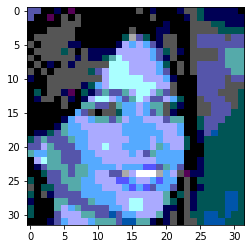

In [0]:
show(DATA['train'][0])

In [0]:
class Resnet(nn.Module):
    def __init__(self, ch_in, n_filters=256, n_blocks=8):
        super(Resnet,self).__init__()
        ch_out = ch_in * 2
        self.n_blocks = n_blocks
        self.conv1 = nn.Conv2d(ch_in, n_filters, kernel_size=(3, 3), stride=(1, 1), padding=2)
        get_ht_model = lambda: nn.Sequential(
            nn.Conv2d(n_filters, n_filters, kernel_size=(1, 1), stride=(1, 1), padding=0),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_filters, kernel_size=(3, 3), stride=(1, 1), padding=1)
        )
        get_h_model = lambda: nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(n_filters, n_filters, kernel_size=(1,1), stride=(1, 1), padding=0)
        )
        self._h_model = torch.nn.ModuleList([get_ht_model() for _ in range(n_blocks)])
        self.h_model = torch.nn.ModuleList([get_h_model() for _ in range(n_blocks)])
        #self.h_sum = torch.nn.ModuleList([nn.ReLU() for _ in range(n_blocks)])
        self.conv2 = nn.Conv2d(n_filters, ch_out, kernel_size=(3, 3), stride=(1, 1))
    
    def forward(self, x):
        h = self.conv1(x)
        for i in range(self.n_blocks):
            _h = self._h_model[i](h)
            h = self.h_model[i](_h)
            h = (h + _h)
        h = F.relu(h)
        x = self.conv2(h)
        return x

In [0]:
Resnet(3, 2)(torch.randn((64, 3, 32, 32))).shape

torch.Size([64, 6, 32, 32])

In [0]:
class AffineCoupling(nn.Module):
    def __init__(self, ch_in):
        super(AffineCoupling, self).__init__()
        self.resnet = Resnet(ch_in)
    def forward(self, x):
      (x1, x2) = x
      y1 = x1
      log_s, t = torch.chunk(self.resnet(x1), 2, dim=1)
      y2 = torch.exp(log_s) * (y1 + t)
      log_det = log_s.view(x1.shape[0], -1).sum(dim=1)
      return ((y1, y2), log_det)

In [0]:
for out in AffineCoupling(3)((torch.randn((5, 3, 32, 32)), torch.randn((5, 3, 32, 32))))[0]:
  print(out.shape)
AffineCoupling(3)((torch.randn((5, 3, 32, 32)), torch.randn((5, 3, 32, 32))))[1].shape

torch.Size([5, 3, 32, 32])
torch.Size([5, 3, 32, 32])


torch.Size([5])

In [0]:
class CelebA(nn.Module):
  def __init__(self, ch_in):
      super(CelebA, self).__init__()
      self.prior = Normal(torch.tensor(0.).to(DEVICE), torch.tensor(1.).to(DEVICE))
      self.couplings1 = torch.nn.ModuleList([AffineCoupling(ch_in) for _ in range(4)])
      self.couplings2 = torch.nn.ModuleList([AffineCoupling(ch_in * 2) for _ in range(3)])
      self.couplings3 = torch.nn.ModuleList([AffineCoupling(ch_in * 4) for _ in range(3)])
      self.couplings4 = torch.nn.ModuleList([AffineCoupling(ch_in * 8) for _ in range(3)])
      self.couplings5 = torch.nn.ModuleList([AffineCoupling(ch_in * 16) for _ in range(3)])

  def build_mask(self, size, config=1.):
      mask = np.arange(size).reshape(-1, 1) + np.arange(size)
      mask = np.mod(config + mask, 2)
      mask = mask.reshape(-1, 1, size, size)
      return torch.tensor(mask.astype('float32'))

  def flip_tuple(self, x):
      (x1, x2) = x
      return (x2, x1)

  def checkerboard_split(self, x):
      mask = self.build_mask(x.shape[2], config=0.).to(DEVICE)
      return (x * mask, x * (1 - mask)) # TODO: is it correct split?

  def inverse_checkerboard_split(self, x):
      return x[0] + x[1] # TODO: is it correct split?

  def squeeze(self, x):
      x = x.permute(0, 2, 3, 1)
      x = x.reshape(-1, x.shape[1] // 2, x.shape[2] // 2, 4 * x.shape[3])
      x = x.permute(0, 3, 1, 2)
      return x

  def channel_split(self, x):
      return torch.chunk(x, 2, dim=1)

  def inverse_channel_split(self, x):
      return torch.cat([x[0], x[1]], dim=1)

  def forward(self, x):
      log_det = 0

      x = self.checkerboard_split(x) 
      for i in range(4):
          x, log_det_temp = self.couplings1[i](x)
          log_det += log_det_temp
          x = self.flip_tuple(x)
      x = self.inverse_checkerboard_split(x)
      
      x = self.squeeze(x)
      
      x = self.channel_split(x)
      for i in range(3):
          x, log_det_temp = self.couplings2[i](x)
          log_det += log_det_temp
          x = self.flip_tuple(x)
      x = self.inverse_channel_split(x)

      x = self.checkerboard_split(x)
      for i in range(3):
          x, log_det_temp = self.couplings3[i](x)
          log_det += log_det_temp
          x = self.flip_tuple(x)
      x = self.inverse_checkerboard_split(x)
      
      x = self.squeeze(x)
      
      x = self.channel_split(x)
      for i in range(3):
          x, log_det_temp = self.couplings4[i](x)
          log_det += log_det_temp
          x = self.flip_tuple(x)
      x = self.inverse_channel_split(x)

      x = self.checkerboard_split(x)
      for i in range(3):
          x, log_det_temp = self.couplings5[i](x)
          log_det += log_det_temp
          x = self.flip_tuple(x)
      x = self.inverse_checkerboard_split(x)

      return x, log_det
    
  def log_prob(self, x):
      z, log_det_J = self.forward(x)
      log_prior_prob = torch.sum(self.prior.log_prob(z), dim=(1, 2, 3))
      return log_prior_prob + log_det_J

In [0]:
CelebA(3).to(DEVICE).log_prob(torch.randn((5, 3, 32, 32)).to(DEVICE))

tensor([-13554.7695, -14249.4619, -15598.8584, -16091.0342, -15630.9756],
       device='cuda:0', grad_fn=<AddBackward0>)

In [0]:
BATCH_SIZE = 32
TRAIN_DATALOADER = DataLoader(DATA['train'], batch_size=BATCH_SIZE, shuffle=True)
TEST_DATALOADER = DataLoader(DATA['test'], batch_size=BATCH_SIZE, shuffle=False)

In [0]:
MODEL = CelebA(3).to(DEVICE)

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
count_parameters(MODEL)

TypeError: ignored